# Titanic

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).



## Expected steps:

1. Check every categorical feature and convert it to one-hot encoding
2. Do EDA for continuous features. <br/>
    (Using this sequence help ensure that all categorical variables have been converted to one-hot encoding to ensure that we are able to use them for Imputing values in Age variable)


## Outlier Detection:
1. IQR or Windsorization
2. Based of Skew. Should range between -1 (left-skewed) and 1 (right skewed)
3. Boxplot
4. Histogram
5. Scatterplot (for two variables)

## How to address Outliers:
1. Quartile based cealing and flooring
2. Log transformation -> log, sq. root or square


In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import shapiro
import math

# Ignoring all warnings
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth',3000)



In [53]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
#gender = pd.read_csv('gender_submission.csv')
def_train = pd.read_csv('train.csv')

In [54]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [84]:
def preprocess_categorical_data(data):
    data = data.copy()
    # PassengerID -> to be dropped
    data.drop(['PassengerId'], axis=1, inplace=True)
    # Pclass -> no preprocessing needed
    # Name -> Preprocessing:
    data['LastName'] = data.Name.str.split(',', expand=True)[0]
    data['PaTitle'] = (data.Name.str.split(',', expand=True)[1].str.split('.', expand=True)[0]).str.strip()

    # Regroup Passanger Titles as Other
    data.loc[~((data['PaTitle'].str.contains('Mrs')) | 
                (data['PaTitle'].str.contains('Miss')) | 
                (data['PaTitle'].str.contains('Mr')) | 
                (data['PaTitle'].str.contains('Master'))), 'PaTitle'  ] = 'Others'
    
    # Drop the name column as its of no use now
    data.drop(['Name', 'LastName'], axis=1, inplace=True)

    # Create Dummy_data
    data = pd.get_dummies(data, columns=['PaTitle'], drop_first=True)

    # Sex -> One-hot-encoding
    data = pd.get_dummies(data, columns=['Sex'], drop_first=True).rename(columns={'Sex_male':'Sex'})

    #SibSp -> Removing extreme values
    # Any SibSp >= 4, is set yo 4
    data['SibSp'] = data['SibSp'].apply(lambda x: 4 if x>3 else x)    
    
    #Parch -> Removing extreme values
    data['Parch'] = data['Parch'].apply(lambda x: 3 if x>2 else x)  

    # Ticket -> Creating a column, 'Ticket_count' to count number of same tickets onboard
    data = data.merge(data.groupby(by = 'Ticket').count().rename(columns={'Survived':'Ticket_Count'})['Ticket_Count'], on='Ticket', how='left')

    #print(data.PaTitle.value_counts())
    return data





In [85]:
def_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [86]:
temp = preprocess_categorical_data(def_train)
temp.head()

,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,PaTitle_Miss,PaTitle_Mr,PaTitle_Mrs,PaTitle_Others,Sex
0,0,3,22.0,1,0,A/5 21171,7.2500,NaN,S,0,1,0,0,1
1,1,1,38.0,1,0,PC 17599,71.2833,C85,C,0,0,1,0,0
2,1,3,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,0,0,0,0
3,1,1,35.0,1,0,113803,53.1000,C123,S,0,0,1,0,0
4,0,3,35.0,0,0,373450,8.0500,NaN,S,0,1,0,0,1


In [87]:
temp.Parch.value_counts()

0    678
1    118
2     80
3     15
Name: Parch, dtype: int64

## <b>Ticket</b>

In [68]:
# Understand what same ticket for several passanges means

train.sort_values('Ticket')

,Survived,Pclass,SibSp,Parch,Ticket,Cabin,Embarked,Age,Fare,PaTitle_Miss,PaTitle_Mr,PaTitle_Mrs,PaTitle_Others,Sex
504,1,1,0,0,110152,B79,S,16.0,86.500,1,0,0,0,0
257,1,1,0,0,110152,B77,S,30.0,86.500,1,0,0,0,0
759,1,1,0,0,110152,B77,S,33.0,86.500,0,0,0,1,0
262,0,1,1,1,110413,E67,S,52.0,79.650,0,1,0,0,1
558,1,1,1,1,110413,E67,S,39.0,79.650,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,0,3,0,0,W./C. 6609,NaN,S,NaN,7.550,1,0,0,0,0
92,0,1,1,0,W.E.P. 5734,E31,S,46.0,61.175,0,1,0,0,1
219,0,2,0,0,W/C 14208,NaN,S,30.0,10.500,0,1,0,0,1
540,1,1,0,2,WE/P 5735,B22,S,36.0,71.000,1,0,0,0,0


In [80]:
train = train.merge(train.groupby(by = 'Ticket').count().rename(columns={'Survived':'Ticket_Count'})['Ticket_Count'], on='Ticket', how='left')

In [87]:
train['Ticket_Cost'] = round(train['Fare']/train['Ticket_Count'], 4)
train.sort_values('Ticket_Count')

,Survived,Pclass,SibSp,Parch,Ticket,Cabin,Embarked,Age,Fare,PaTitle_Miss,PaTitle_Mr,PaTitle_Mrs,PaTitle_Others,Sex,Ticket_Count,Ticket_Cost
0,0,3,1,0,A/5 21171,NaN,S,22.0,7.2500,0,1,0,0,1,1,7.2500
510,1,3,0,0,382651,NaN,Q,29.0,7.7500,0,1,0,0,1,1,7.7500
511,0,3,0,0,SOTON/OQ 3101316,NaN,S,NaN,8.0500,0,1,0,0,1,1,8.0500
512,1,1,0,0,PC 17473,E25,S,36.0,26.2875,0,1,0,0,1,1,26.2875
513,1,1,1,0,PC 17603,NaN,C,54.0,59.4000,0,0,1,0,0,1,59.4000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
838,1,3,0,0,1601,NaN,S,32.0,56.4958,0,1,0,0,1,7,8.0708
846,0,3,4,2,CA. 2343,NaN,S,NaN,69.5500,0,1,0,0,1,7,9.9357
850,0,3,4,2,347082,NaN,S,4.0,31.2750,0,0,0,0,1,7,4.4679
826,0,3,0,0,1601,NaN,S,NaN,56.4958,0,1,0,0,1,7,8.0708


In [100]:
train.drop('Ticket', axis=1, inplace=True)

## <b>Cabin</b>

In [98]:
train['Cabin_NA'] = train.Cabin.isnull().astype(int)
train.drop('Cabin', axis=1, inplace=True)

## <b>Embark</b>

In [125]:
train['Embarked'].mode()[0]

'S'

In [127]:
train['Embarked'].fillna(train['Embarked'].mode()[0], inplace=True)

In [128]:
train.Embarked.value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

<AxesSubplot:xlabel='Embarked', ylabel='count'>

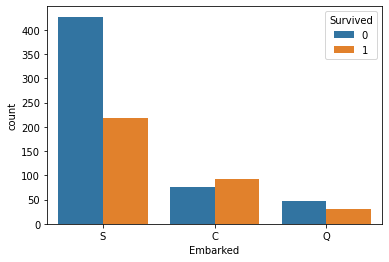

In [131]:
sns.countplot(x='Embarked', hue='Survived', data=train)

In [133]:
train = pd.get_dummies(train, columns=['Embarked'], drop_first=True)

### <b>Age</b>

1. Outlier Treatment -> Use winsorization to replace last 99th percentile outlier. Use replacing technique instead of dropping the outlier here. 
2. Imputing Missing data -> we will us KNNImputer to impute missing data

,Survived,Pclass,SibSp,Parch,Age,Fare,PaTitle_Miss,PaTitle_Mr,PaTitle_Mrs,PaTitle_Others,Sex,Ticket_Count,Ticket_Cost,Cabin_NA,Embarked_Q,Embarked_S
Age,0.077221,0.369226,0.308269,0.240955,1.000000,0.096067,0.276792,0.206341,0.180278,0.169880,0.093254,0.253507,0.227631,0.249732,0.022405,0.023233
Pclass,0.338481,1.000000,0.067096,0.002457,0.369226,0.549500,0.000576,0.142698,0.149209,0.206333,0.131900,0.002633,0.655559,0.725541,0.221009,0.074053
SibSp,0.010680,0.067096,1.000000,0.468342,0.308269,0.165933,0.087542,0.288648,0.093442,0.036928,0.135595,0.651345,0.000796,0.026883,0.019443,0.058309
PaTitle_Miss,0.327093,0.000576,0.087542,0.132406,0.276792,0.118271,1.000000,0.595692,0.204670,0.089565,0.686808,0.111744,0.047635,0.035314,0.171117,0.130650
Ticket_Count,0.038247,0.002633,0.651345,0.592265,0.253507,0.345541,0.111744,0.266358,0.086745,0.049441,0.154748,1.000000,0.013854,0.028026,0.072426,0.066575
Cabin_NA,0.316912,0.725541,0.026883,0.052456,0.249732,0.482075,0.035314,0.137319,0.118300,0.106246,0.140391,0.028026,0.560773,1.000000,0.129572,0.101139
Parch,0.106532,0.002457,0.468342,1.000000,0.240955,0.235347,0.132406,0.357406,0.206401,0.071282,0.253454,0.592265,0.078216,0.052456,0.094445,0.059091
Ticket_Cost,0.254824,0.655559,0.000796,0.078216,0.227631,0.839037,0.047635,0.111006,0.106397,0.073465,0.128809,0.013854,1.000000,0.560773,0.126584,0.203115
PaTitle_Mr,0.549199,0.142698,0.288648,0.357406,0.206341,0.183766,0.595692,1.000000,0.474952,0.207843,0.867334,0.266358,0.111006,0.137319,0.078338,0.112870
PaTitle_Mrs,0.339040,0.149209,0.093442,0.206401,0.180278,0.105203,0.204670,0.474952,1.000000,0.071411,0.547600,0.086745,0.106397,0.118300,0.089739,0.002689


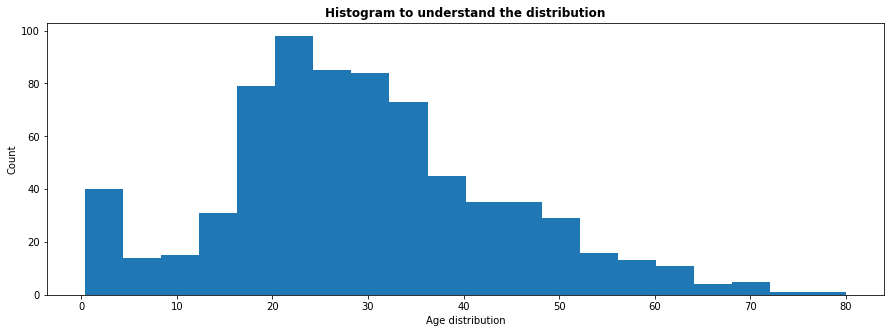

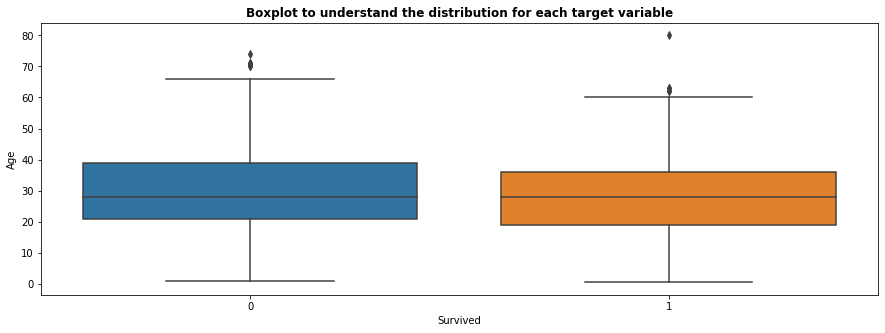

In [141]:
# Histogram to understand the distribution

plt.figure(figsize = (15, 5))
plt.title("Histogram to understand the distribution", fontweight='bold')
plt.xlabel('Age distribution')
plt.ylabel('Count')
plt.hist(train.Age, bins=20);
plt.show()

# Boxplot to understand distribution and check if there are outliers
plt.figure(figsize = (15,5))
plt.title("Boxplot to understand the distribution for each target variable", fontweight='bold')
plt.xlabel('Survived / Not-Survived')
plt.ylabel('Age')
sns.boxplot(y='Age', x='Survived', data=train)
plt.show()

In [142]:
train.Age.skew()

0.38910778230082704

In [143]:
# Outliers (99th Quartile) - two methods
train[~train.Age.isnull()].Age.apply(lambda x: float(x)).quantile(0.99)

train[train.Age >= np.percentile(train[~train.Age.isnull()].Age, 99)]

,Survived,Pclass,SibSp,Parch,Age,Fare,PaTitle_Miss,PaTitle_Mr,PaTitle_Mrs,PaTitle_Others,Sex,Ticket_Count,Ticket_Cost,Cabin_NA,Embarked_Q,Embarked_S
33,0,2,0,0,66.0,10.5000,0,1,0,0,1,1,10.5000,1,0,1
96,0,1,0,0,71.0,34.6542,0,1,0,0,1,1,34.6542,0,0,0
116,0,3,0,0,70.5,7.7500,0,1,0,0,1,1,7.7500,1,1,0
493,0,1,0,0,71.0,49.5042,0,1,0,0,1,1,49.5042,1,0,0
630,1,1,0,0,80.0,30.0000,0,1,0,0,1,1,30.0000,0,0,1
672,0,2,0,0,70.0,10.5000,0,1,0,0,1,1,10.5000,1,0,1
745,0,1,1,1,70.0,71.0000,0,0,0,1,1,2,35.5000,0,0,1
851,0,3,0,0,74.0,7.7750,0,1,0,0,1,1,7.7750,1,0,1


In [144]:
# capturing the ceiling value of outlier in a variable
ceiling = math.ceil(np.percentile(train[~train.Age.isnull()].Age, 99))

# Replacing value of Outlier Age with ceiling
train.loc[train.Age >= ceiling, 'Age'] = ceiling

In [145]:
# QA if the output looks as expected
train[~(train.Age.isnull())].sort_values('Age', ascending=False).head()

,Survived,Pclass,SibSp,Parch,Age,Fare,PaTitle_Miss,PaTitle_Mr,PaTitle_Mrs,PaTitle_Others,Sex,Ticket_Count,Ticket_Cost,Cabin_NA,Embarked_Q,Embarked_S
493,0,1,0,0,66.0,49.5042,0,1,0,0,1,1,49.5042,1,0,0
851,0,3,0,0,66.0,7.7750,0,1,0,0,1,1,7.7750,1,0,1
630,1,1,0,0,66.0,30.0000,0,1,0,0,1,1,30.0000,0,0,1
96,0,1,0,0,66.0,34.6542,0,1,0,0,1,1,34.6542,0,0,0
672,0,2,0,0,66.0,10.5000,0,1,0,0,1,1,10.5000,1,0,1


In [146]:
train.Age.skew()

0.3123094826696491

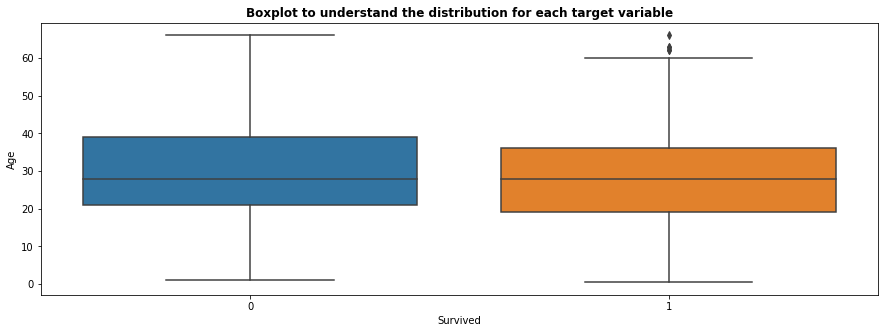

In [150]:
# QA the updated data to ensure the output is as expected
plt.figure(figsize = (15,5))
plt.title("Boxplot to understand the distribution for each target variable", fontweight='bold')
plt.xlabel('Survived / Not-Survived')
plt.ylabel('Age')
sns.boxplot(y='Age', x='Survived', data=train)
plt.show()

# As we can see, outliers have been taken care of

In [151]:
abs(train.corr()).sort_values('Age', ascending=False)

,Survived,Pclass,SibSp,Parch,Age,Fare,PaTitle_Miss,PaTitle_Mr,PaTitle_Mrs,PaTitle_Others,Sex,Ticket_Count,Ticket_Cost,Cabin_NA,Embarked_Q,Embarked_S
Age,0.077351,0.370684,0.310010,0.242039,1.000000,0.097753,0.277956,0.205766,0.184306,0.170707,0.091090,0.254207,0.229083,0.250215,0.024063,0.022421
Pclass,0.338481,1.000000,0.067096,0.002457,0.370684,0.549500,0.000576,0.142698,0.149209,0.206333,0.131900,0.002633,0.655559,0.725541,0.221009,0.074053
SibSp,0.010680,0.067096,1.000000,0.468342,0.310010,0.165933,0.087542,0.288648,0.093442,0.036928,0.135595,0.651345,0.000796,0.026883,0.019443,0.058309
PaTitle_Miss,0.327093,0.000576,0.087542,0.132406,0.277956,0.118271,1.000000,0.595692,0.204670,0.089565,0.686808,0.111744,0.047635,0.035314,0.171117,0.130650
Ticket_Count,0.038247,0.002633,0.651345,0.592265,0.254207,0.345541,0.111744,0.266358,0.086745,0.049441,0.154748,1.000000,0.013854,0.028026,0.072426,0.066575
Cabin_NA,0.316912,0.725541,0.026883,0.052456,0.250215,0.482075,0.035314,0.137319,0.118300,0.106246,0.140391,0.028026,0.560773,1.000000,0.129572,0.101139
Parch,0.106532,0.002457,0.468342,1.000000,0.242039,0.235347,0.132406,0.357406,0.206401,0.071282,0.253454,0.592265,0.078216,0.052456,0.094445,0.059091
Ticket_Cost,0.254824,0.655559,0.000796,0.078216,0.229083,0.839037,0.047635,0.111006,0.106397,0.073465,0.128809,0.013854,1.000000,0.560773,0.126584,0.203115
PaTitle_Mr,0.549199,0.142698,0.288648,0.357406,0.205766,0.183766,0.595692,1.000000,0.474952,0.207843,0.867334,0.266358,0.111006,0.137319,0.078338,0.112870
PaTitle_Mrs,0.339040,0.149209,0.093442,0.206401,0.184306,0.105203,0.204670,0.474952,1.000000,0.071411,0.547600,0.086745,0.106397,0.118300,0.089739,0.002689


In [154]:
abs(train.corr()).sort_values('Age', ascending=False).index

Index(['Age', 'Pclass', 'SibSp', 'PaTitle_Miss', 'Ticket_Count', 'Cabin_NA',
       'Parch', 'Ticket_Cost', 'PaTitle_Mr', 'PaTitle_Mrs', 'PaTitle_Others',
       'Fare', 'Sex', 'Survived', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [155]:
# Imputing missing data using KNNImputer

X = train.copy()

# Selecting columns that will help to determine the age. We will use Pclass, SubSp, Parch, Fare and Sex_male to create KNN model to impute age
X = X[['Pclass', 'SibSp', 'PaTitle_Miss', 'Ticket_Count', 'Cabin_NA',
       'Parch', 'Ticket_Cost', 'PaTitle_Mr', 'PaTitle_Mrs', 'PaTitle_Others',
       'Fare', 'Sex', 'Age']]

In [156]:
from sklearn.impute import KNNImputer
impute_knn = KNNImputer(n_neighbors=2)
X_impute = impute_knn.fit_transform(X)

X_impute = pd.DataFrame(X_impute, columns=X.columns)
X_impute.Age = X_impute.Age.round(2)

# Update the working DF with imputed Age
train['Age'] = X_impute['Age']


There is another imputer that uses Linear Regression to impute values:

```
from sklearn.impute import IterativeImputer
impute_it = IterativeImputer()
y = impute_it.fit_transform(X)
```


In [157]:
train[(train.PaTitle_Miss == 0) & (train.PaTitle_Mr == 0) & (train.PaTitle_Mrs == 0) & (train.PaTitle_Others == 0) ].sort_values('Age')

,Survived,Pclass,SibSp,Parch,Age,Fare,PaTitle_Miss,PaTitle_Mr,PaTitle_Mrs,PaTitle_Others,Sex,Ticket_Count,Ticket_Cost,Cabin_NA,Embarked_Q,Embarked_S
803,1,3,0,1,0.42,8.5167,0,0,0,0,1,1,8.5167,1,0,0
755,1,2,1,1,0.67,14.5000,0,0,0,0,1,2,7.2500,1,0,1
831,1,2,1,1,0.83,18.7500,0,0,0,0,1,3,6.2500,1,0,1
78,1,2,0,2,0.83,29.0000,0,0,0,0,1,2,14.5000,1,0,1
305,1,1,1,2,0.92,151.5500,0,0,0,0,1,4,37.8875,0,0,1
827,1,2,0,2,1.00,37.0042,0,0,0,0,1,2,18.5021,1,0,0
788,1,3,1,2,1.00,20.5750,0,0,0,0,1,2,10.2875,1,0,1
386,0,3,4,2,1.00,46.9000,0,0,0,0,1,6,7.8167,1,0,1
164,0,3,4,1,1.00,39.6875,0,0,0,0,1,6,6.6146,1,0,1
183,1,2,2,1,1.00,39.0000,0,0,0,0,1,2,19.5000,0,0,1


In [159]:
train

,Survived,Pclass,SibSp,Parch,Age,Fare,PaTitle_Miss,PaTitle_Mr,PaTitle_Mrs,PaTitle_Others,Sex,Ticket_Count,Ticket_Cost,Cabin_NA,Embarked_Q,Embarked_S
0,0,3,1,0,22.0,7.2500,0,1,0,0,1,1,7.2500,1,0,1
1,1,1,1,0,38.0,71.2833,0,0,1,0,0,1,71.2833,0,0,0
2,1,3,0,0,26.0,7.9250,1,0,0,0,0,1,7.9250,1,0,1
3,1,1,1,0,35.0,53.1000,0,0,1,0,0,2,26.5500,0,0,1
4,0,3,0,0,35.0,8.0500,0,1,0,0,1,1,8.0500,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,0,0,27.0,13.0000,0,0,0,1,1,1,13.0000,1,0,1
887,1,1,0,0,19.0,30.0000,1,0,0,0,0,1,30.0000,0,0,1
888,0,3,1,2,26.0,23.4500,1,0,0,0,0,2,11.7250,1,0,1
889,1,1,0,0,26.0,30.0000,0,1,0,0,1,1,30.0000,0,0,0


In [160]:
abs(train.corr()).sort_values('Fare', ascending=False)

,Survived,Pclass,SibSp,Parch,Age,Fare,PaTitle_Miss,PaTitle_Mr,PaTitle_Mrs,PaTitle_Others,Sex,Ticket_Count,Ticket_Cost,Cabin_NA,Embarked_Q,Embarked_S
Fare,0.257307,0.549500,0.165933,0.235347,0.088317,1.000000,0.118271,0.183766,0.105203,0.024585,0.182333,0.345541,0.839037,0.482075,0.117216,0.162184
Ticket_Cost,0.254824,0.655559,0.000796,0.078216,0.210639,0.839037,0.047635,0.111006,0.106397,0.073465,0.128809,0.013854,1.000000,0.560773,0.126584,0.203115
Pclass,0.338481,1.000000,0.067096,0.002457,0.354714,0.549500,0.000576,0.142698,0.149209,0.206333,0.131900,0.002633,0.655559,0.725541,0.221009,0.074053
Cabin_NA,0.316912,0.725541,0.026883,0.052456,0.236118,0.482075,0.035314,0.137319,0.118300,0.106246,0.140391,0.028026,0.560773,1.000000,0.129572,0.101139
Ticket_Count,0.038247,0.002633,0.651345,0.592265,0.240309,0.345541,0.111744,0.266358,0.086745,0.049441,0.154748,1.000000,0.013854,0.028026,0.072426,0.066575
Survived,1.000000,0.338481,0.010680,0.106532,0.097632,0.257307,0.327093,0.549199,0.339040,0.022030,0.543351,0.038247,0.254824,0.316912,0.003650,0.149683
Parch,0.106532,0.002457,0.468342,1.000000,0.245824,0.235347,0.132406,0.357406,0.206401,0.071282,0.253454,0.592265,0.078216,0.052456,0.094445,0.059091
PaTitle_Mr,0.549199,0.142698,0.288648,0.357406,0.238641,0.183766,0.595692,1.000000,0.474952,0.207843,0.867334,0.266358,0.111006,0.137319,0.078338,0.112870
Sex,0.543351,0.131900,0.135595,0.253454,0.134221,0.182333,0.686808,0.867334,0.547600,0.034471,1.000000,0.154748,0.128809,0.140391,0.074115,0.119224
SibSp,0.010680,0.067096,1.000000,0.468342,0.287930,0.165933,0.087542,0.288648,0.093442,0.036928,0.135595,0.651345,0.000796,0.026883,0.019443,0.058309


In [161]:
abs(train.corr()).sort_values('Ticket_Cost', ascending=False)

,Survived,Pclass,SibSp,Parch,Age,Fare,PaTitle_Miss,PaTitle_Mr,PaTitle_Mrs,PaTitle_Others,Sex,Ticket_Count,Ticket_Cost,Cabin_NA,Embarked_Q,Embarked_S
Ticket_Cost,0.254824,0.655559,0.000796,0.078216,0.210639,0.839037,0.047635,0.111006,0.106397,0.073465,0.128809,0.013854,1.000000,0.560773,0.126584,0.203115
Fare,0.257307,0.549500,0.165933,0.235347,0.088317,1.000000,0.118271,0.183766,0.105203,0.024585,0.182333,0.345541,0.839037,0.482075,0.117216,0.162184
Pclass,0.338481,1.000000,0.067096,0.002457,0.354714,0.549500,0.000576,0.142698,0.149209,0.206333,0.131900,0.002633,0.655559,0.725541,0.221009,0.074053
Cabin_NA,0.316912,0.725541,0.026883,0.052456,0.236118,0.482075,0.035314,0.137319,0.118300,0.106246,0.140391,0.028026,0.560773,1.000000,0.129572,0.101139
Survived,1.000000,0.338481,0.010680,0.106532,0.097632,0.257307,0.327093,0.549199,0.339040,0.022030,0.543351,0.038247,0.254824,0.316912,0.003650,0.149683
Age,0.097632,0.354714,0.287930,0.245824,1.000000,0.088317,0.298552,0.238641,0.157570,0.152903,0.134221,0.240309,0.210639,0.236118,0.000698,0.024696
Embarked_S,0.149683,0.074053,0.058309,0.059091,0.024696,0.162184,0.130650,0.112870,0.002689,0.052433,0.119224,0.066575,0.203115,0.101139,0.499421,1.000000
Sex,0.543351,0.131900,0.135595,0.253454,0.134221,0.182333,0.686808,0.867334,0.547600,0.034471,1.000000,0.154748,0.128809,0.140391,0.074115,0.119224
Embarked_Q,0.003650,0.221009,0.019443,0.094445,0.000698,0.117216,0.171117,0.078338,0.089739,0.007767,0.074115,0.072426,0.126584,0.129572,1.000000,0.499421
PaTitle_Mr,0.549199,0.142698,0.288648,0.357406,0.238641,0.183766,0.595692,1.000000,0.474952,0.207843,0.867334,0.266358,0.111006,0.137319,0.078338,0.112870


4.787316519674893

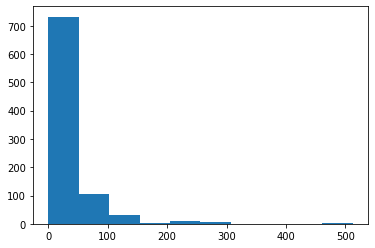

In [165]:
plt.hist(train.Fare);
train.Fare.skew()

4.380561523143281

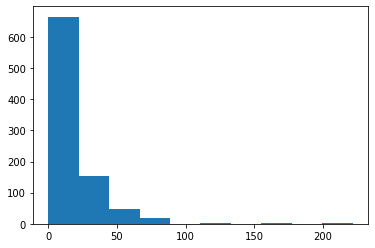

In [166]:
plt.hist(train.Ticket_Cost)
train.Ticket_Cost.skew()


In [173]:
np.log(train.Ticket_Cost +1 ).sort_values().skew()

0.3302208829499277

In [183]:
np.log(train.Fare +1 ).sort_values().skew()

0.3949280095189299

(array([ 15.,   0.,   4., 155., 444.,  50., 150.,  56.,  10.,   7.]),
 array([0.        , 0.54061811, 1.08123623, 1.62185434, 2.16247246,
        2.70309057, 3.24370869, 3.7843268 , 4.32494492, 4.86556303,
        5.40618115]),
 <BarContainer object of 10 artists>)

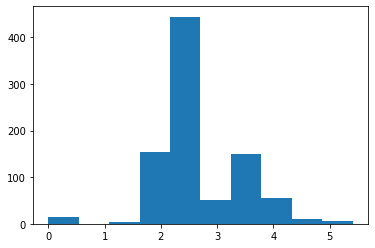

In [174]:
plt.hist(np.log(train.Ticket_Cost +1))

(array([ 15.,   0.,   2., 350., 167., 182.,  85.,  59.,  28.,   3.]),
 array([0.        , 0.62409174, 1.24818347, 1.87227521, 2.49636694,
        3.12045868, 3.74455041, 4.36864215, 4.99273388, 5.61682562,
        6.24091735]),
 <BarContainer object of 10 artists>)

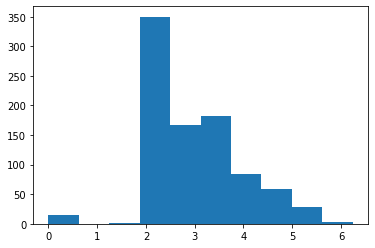

In [182]:
plt.hist(np.log(train.Fare +1))

In [186]:
#temp = train.copy()
train['log_fare'] = np.log(train.Fare +1)
train['log_Ticket_Cost'] = np.log(train.Ticket_Cost +1)
train

,Survived,Pclass,SibSp,Parch,Age,Fare,PaTitle_Miss,PaTitle_Mr,PaTitle_Mrs,PaTitle_Others,Sex,Ticket_Count,Ticket_Cost,Cabin_NA,Embarked_Q,Embarked_S,log_fare,log_Ticket_Cost
0,0,3,1,0,22.0,7.2500,0,1,0,0,1,1,7.2500,1,0,1,2.110213,2.110213
1,1,1,1,0,38.0,71.2833,0,0,1,0,0,1,71.2833,0,0,0,4.280593,4.280593
2,1,3,0,0,26.0,7.9250,1,0,0,0,0,1,7.9250,1,0,1,2.188856,2.188856
3,1,1,1,0,35.0,53.1000,0,0,1,0,0,2,26.5500,0,0,1,3.990834,3.316003
4,0,3,0,0,35.0,8.0500,0,1,0,0,1,1,8.0500,1,0,1,2.202765,2.202765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,0,0,27.0,13.0000,0,0,0,1,1,1,13.0000,1,0,1,2.639057,2.639057
887,1,1,0,0,19.0,30.0000,1,0,0,0,0,1,30.0000,0,0,1,3.433987,3.433987
888,0,3,1,2,26.0,23.4500,1,0,0,0,0,2,11.7250,1,0,1,3.196630,2.543569
889,1,1,0,0,26.0,30.0000,0,1,0,0,1,1,30.0000,0,0,0,3.433987,3.433987


In [190]:
train[['Age', 'Fare', 'Ticket_Cost', 'log_fare', 'log_Ticket_Cost']].skew()

Age                0.379887
Fare               4.787317
Ticket_Cost        4.380562
log_fare           0.394928
log_Ticket_Cost    0.330221
dtype: float64

# <b>Classification</b>

In [51]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [52]:
train[train.Age.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S


In [53]:
temp = train.sort_values('Age', ascending=False)

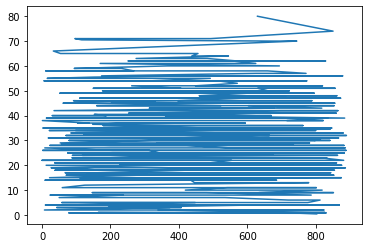

In [54]:
plt.plot(temp['Age'])

<AxesSubplot:xlabel='Age'>

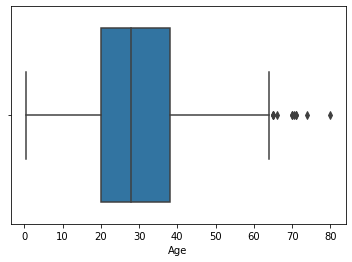

In [55]:
# Check if Age is normally distributed?
sns.boxplot(train['Age'])


In [47]:
stats, p = shapiro(train[~train.Age.isnull()]['Age'])

print('Stats = %.3f , p = %.3f ' % (stats,  p))

#Shapiro-Wilk Test assumes that distribution is not normal

Stats = 0.981 , p = 0.000 


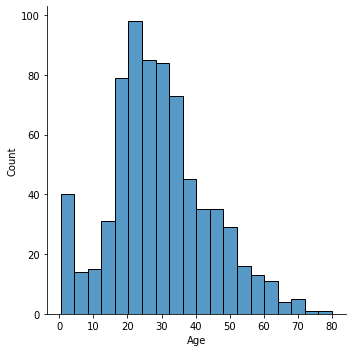

In [33]:
sns.displot(train['Age'])

In [30]:
measurements = np.random.normal(size=150)

<AxesSubplot:>

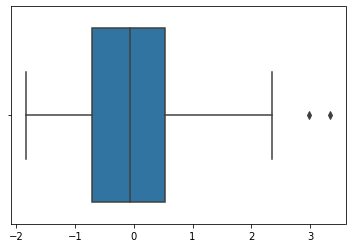

In [32]:
sns.boxplot(measurements)


In [73]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [72]:
train.drop('Cabin', axis=1, inplace=True)

In [74]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C


In [82]:
train = pd.get_dummies(train, columns=['Sex', 'Embarked'], drop_first=True)

In [83]:
train

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Sex_male,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,0,0,1
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",27.0,0,0,211536,13.0000,1,0,1
887,888,1,1,"Graham, Miss. Margaret Edith",19.0,0,0,112053,30.0000,0,0,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",NaN,1,2,W./C. 6607,23.4500,0,0,1
889,890,1,1,"Behr, Mr. Karl Howell",26.0,0,0,111369,30.0000,1,0,0


In [85]:
train.Ticket.nunique()

681

In [93]:
train[train.Ticket == '110465']

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Sex_male,Embarked_Q,Embarked_S
110,111,0,1,"Porter, Mr. Walter Chamberlain",47.0,0,0,110465,52.0,1,0,1
475,476,0,1,"Clifford, Mr. George Quincy",NaN,0,0,110465,52.0,1,0,1


In [101]:
temp = train[train.duplicated(subset=['Ticket'], keep=False)].sort_values('Ticket').reset_index()

In [104]:
temp.head(50)

,index,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Sex_male,Embarked_Q,Embarked_S
0,257,258,1,1,"Cherry, Miss. Gladys",30.00,0,0,110152,86.5000,0,0,1
1,759,760,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",33.00,0,0,110152,86.5000,0,0,1
2,504,505,1,1,"Maioni, Miss. Roberta",16.00,0,0,110152,86.5000,0,0,1
3,262,263,0,1,"Taussig, Mr. Emil",52.00,1,1,110413,79.6500,1,0,1
4,558,559,1,1,"Taussig, Mrs. Emil (Tillie Mandelbaum)",39.00,1,1,110413,79.6500,0,0,1
5,585,586,1,1,"Taussig, Miss. Ruth",18.00,0,2,110413,79.6500,0,0,1
6,110,111,0,1,"Porter, Mr. Walter Chamberlain",47.00,0,0,110465,52.0000,1,0,1
7,475,476,0,1,"Clifford, Mr. George Quincy",NaN,0,0,110465,52.0000,1,0,1
8,523,524,1,1,"Hippach, Mrs. Louis Albert (Ida Sophia Fischer)",44.00,0,1,111361,57.9792,0,0,0
9,329,330,1,1,"Hippach, Miss. Jean Gertrude",16.00,0,1,111361,57.9792,0,0,0
